In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from dist3 import create_task
import skimage.transform as st
#from esbn_pytorch import ESBN

In [2]:
from util import log
from modules import *

In [3]:
class Encoder_conv(nn.Module):
	#def __init__(self, args):
	def __init__(self):
		super(Encoder_conv, self).__init__()
		log.info('Building convolutional encoder...')
		# Convolutional layers
		log.info('Conv layers...')
		
		self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(32, 32, 4, stride=2, padding=1)
		'''
		self.conv1 = nn.Conv2d(1, 160, 4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(160, 160, 4, stride=2, padding=1)
		'''   
		# Fully-connected layers
		log.info('FC layers...')
		self.fc1 = nn.Linear(4*4*32, 256)
		self.fc2 = nn.Linear(256, 128)
		#self.fc1 = nn.Linear(64000, 256)
		#self.fc2 = nn.Linear(256, 128)
		# Nonlinearities
		self.relu = nn.ReLU()
		# Initialize parameters
		for name, param in self.named_parameters():
			# Initialize all biases to 0
			if 'bias' in name:
				nn.init.constant_(param, 0.0)
			# Initialize all pre-ReLU weights using Kaiming normal distribution
			elif 'weight' in name:
				nn.init.kaiming_normal_(param, nonlinearity='relu')
	def forward(self, x):
		# Convolutional layers
		conv1_out = self.relu(self.conv1(x))
		conv2_out = self.relu(self.conv2(conv1_out))
		conv3_out = self.relu(self.conv3(conv2_out))
		# Flatten output of conv. net
		conv3_out_flat = torch.flatten(conv3_out, 1)
		# Fully-connected layers
		#print("conv3_out_flat.size() =",conv3_out_flat.size())
		#time.sleep(120)
		fc1_out = self.relu(self.fc1(conv3_out_flat))
		fc2_out = self.relu(self.fc2(fc1_out))
		# Output
		z = fc2_out
		return z

In [4]:
class Model(nn.Module):
	#def __init__(self, task_gen, args):
	def __init__(self):
		super(Model, self).__init__()
		# Encoder
		log.info('Building encoder...')
		'''
		if args.encoder == 'conv':
			self.encoder = Encoder_conv(args)
		elif args.encoder == 'mlp':
			self.encoder = Encoder_mlp(args)
		elif args.encoder == 'rand':
			self.encoder = Encoder_rand(args)
		'''
		self.encoder = Encoder_conv()# removed "args" argument
		# LSTM and output layers
		log.info('Building LSTM and output layers...')
		self.z_size = 128
		self.key_size = 256
		self.hidden_size = 512
		self.lstm = nn.LSTM(self.key_size + 1, self.hidden_size, batch_first=True)
		self.key_w_out = nn.Linear(self.hidden_size, self.key_size)
		self.g_out = nn.Linear(self.hidden_size, 1)
		self.confidence_gain = nn.Parameter(torch.ones(1))
		self.confidence_bias = nn.Parameter(torch.zeros(1))
		#self.y_out = nn.Linear(self.hidden_size, task_gen.y_dim)
		y_out = 8 # number of outputs/ ESBN = 4
		self.y_out = nn.Linear(self.hidden_size, y_out)
		# Context normalization
		#if args.norm_type == 'contextnorm' or args.norm_type == 'tasksegmented_contextnorm':
		if True: # assumes "contextnorm or tasksegmented_contextnorm"
			self.contextnorm = True
			self.gamma = nn.Parameter(torch.ones(self.z_size))
			self.beta = nn.Parameter(torch.zeros(self.z_size))
		else:
			self.contextnorm = False
		'''
		if args.norm_type == 'tasksegmented_contextnorm':
			self.task_seg = task_gen.task_seg
		else:
			self.task_seg = [np.arange(task_gen.seq_len)]
		'''
		seq_len = 16 # number of images per Raven problem / ESBN = 9        
		self.task_seg = [np.arange(seq_len)]
		# Nonlinearities
		self.relu = nn.ReLU()
		self.sigmoid = nn.Sigmoid()
		self.softmax = nn.Softmax(dim=1)
		# Initialize parameters
		for name, param in self.named_parameters():
			# Encoder parameters have already been initialized
			if not ('encoder' in name) and not ('confidence' in name):
				# Initialize all biases to 0
				if 'bias' in name:
					nn.init.constant_(param, 0.0)
				else:
					if 'lstm' in name:
						# Initialize gate weights (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param[:self.hidden_size*2,:])
						nn.init.xavier_normal_(param[self.hidden_size*3:,:])
						# Initialize input->hidden and hidden->hidden weights (followed by tanh) using Xavier normal distribution with gain = 
						nn.init.xavier_normal_(param[self.hidden_size*2:self.hidden_size*3,:], gain=5.0/3.0)
					elif 'key_w' in name:
						# Initialize weights for key output layer (followed by ReLU) using Kaiming normal distribution
						nn.init.kaiming_normal_(param, nonlinearity='relu')
					elif 'g_out' in name:
						# Initialize weights for gate output layer (followed by sigmoid) using Xavier normal distribution
						nn.init.xavier_normal_(param)
					elif 'y_out' in name:
						# Initialize weights for multiple-choice output layer (followed by softmax) using Xavier normal distribution
						nn.init.xavier_normal_(param)
	def forward(self, x_seq, device):
		# Encode all images in sequence
		z_seq = []
		for t in range(x_seq.shape[1]):
			x_t = x_seq[:,t,:,:].unsqueeze(1)
			z_t = self.encoder(x_t)
			z_seq.append(z_t)
		z_seq = torch.stack(z_seq, dim=1)
		if self.contextnorm:
			z_seq_all_seg = []
			for seg in range(len(self.task_seg)):
				z_seq_all_seg.append(self.apply_context_norm(z_seq[:,self.task_seg[seg],:]))
			z_seq = torch.cat(z_seq_all_seg, dim=1)
		# Initialize hidden state
		hidden = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		cell_state = torch.zeros(1, x_seq.shape[0], self.hidden_size).to(device)
		# Initialize retrieved key vector
		key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
		# Memory model (extra time step to process key retrieved on final time step)
		for t in range(x_seq.shape[1] + 1):
			# Image embedding
			if t == x_seq.shape[1]:
				z_t = torch.zeros(x_seq.shape[0], 1, self.z_size).to(device)
			else:
				z_t = z_seq[:,t,:].unsqueeze(1)
			# Controller
			# LSTM
			lstm_out, (hidden, cell_state) = self.lstm(key_r, (hidden, cell_state))
			# Key output layers
			key_w = self.relu(self.key_w_out(lstm_out))
			# Gates
			g = self.sigmoid(self.g_out(lstm_out))
			# Task output layer
			y_pred_linear = self.y_out(lstm_out).squeeze()
			y_pred = y_pred_linear.argmax(1)
			# Read from memory
			if t == 0:
				key_r = torch.zeros(x_seq.shape[0], 1, self.key_size + 1).to(device)
			else:
				# Read key
				w_k = self.softmax((z_t * M_v).sum(dim=2))
				c_k = self.sigmoid(((z_t * M_v).sum(dim=2) * self.confidence_gain) + self.confidence_bias)
				key_r = g * (torch.cat([M_k, c_k.unsqueeze(2)], dim=2) * w_k.unsqueeze(2)).sum(1).unsqueeze(1)
			# Write to memory
			if t == 0:
				M_k = key_w
				M_v = z_t
			else:
				M_k = torch.cat([M_k, key_w], dim=1)
				M_v = torch.cat([M_v, z_t], dim=1)
		return y_pred_linear, y_pred
	def apply_context_norm(self, z_seq):
		eps = 1e-8
		z_mu = z_seq.mean(1)
		z_sigma = (z_seq.var(1) + eps).sqrt()
		z_seq = (z_seq - z_mu.unsqueeze(1)) / z_sigma.unsqueeze(1)
		z_seq = (z_seq * self.gamma) + self.beta
		return z_seq

In [5]:
def grab_npz_img(img_path):
    data = np.load(img_path)
    img = data['image']
    target = data['target']
    x = img[:,:,:]
    x = st.resize(x, (16, 32, 32))
    #x = np.expand_dims(x, axis=0)
    #x = x.reshape((x.shape[0],x.shape[1],x.shape[2],x.shape[3],1))
    return x

In [6]:
def grab_npz_target(target_path):
    data = np.load(target_path)
    target = data['target']
    y = int(target)
    return y

In [7]:
def create_dataset(folder,num_imgs,config):
    X = []
    #X = np.array(X)
    Y =[]
    #for i in range(num_imgs):
    name = ''
    if config=='train':
        name = 'train'
    elif config=='validate':
        name = 'val'
    else:
        name = 'test'
        
    count = 0
    i = 0
    while count < num_imgs:
        try:
            x = grab_npz_img('/home/asw3x/RAVEN-10000/'+folder+'/RAVEN_%d_%s.npz'%(i,name))
            y = grab_npz_target('/home/asw3x/RAVEN-10000/'+folder+'/RAVEN_%d_%s.npz'%(i,name))
            i += 1
        except:
            i += 1
            continue
        X.append(x)
        #X = np.concatenate(x)
        Y.append(y)
        count += 1
    X = np.array(X)
    X = np.squeeze(X)
    #X = np.expand_dims(X, axis=4)
    #X = X.reshape((X.shape[0],X.shape[2],X.shape[3],X.shape[1]))
    #X = np.moveaxis(X, 1, -1)
    return X,np.array(Y)

In [8]:
def create_task(size=1000, task="center_single"):
    folder = task
    train_size = size
    test_size = train_size*0.4
    
    X_train, Y_train = create_dataset(folder,train_size,"train")
    X_test, Y_test = create_dataset(folder,test_size,"test")
    
    # Create training and test sets
    train_set = {'img_seq': X_train, 'y': Y_train}
    test_set = {'img_seq': X_test, 'y': Y_test}
    return train_set, test_set

In [9]:
training_set,test_set = create_task(size=5000)

In [10]:
training_set['img_seq'].shape

(5000, 16, 32, 32)

In [11]:
training_set['y'].shape

(5000,)

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        '''
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        '''
        self.img_seq = dataset['img_seq']
        self.y = dataset['y']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        '''
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        '''
        img_seq = self.img_seq[idx,:,:,:]
        y = self.y[idx]
        
        return img_seq, y

In [13]:
training_set = CustomImageDataset(training_set)
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)
test_set = CustomImageDataset(test_set)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 16, 32, 32])
Labels batch shape: torch.Size([32])


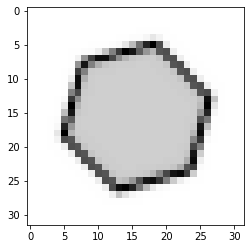

Label: 3


In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 16, 32, 32])
Labels batch shape: torch.Size([32])


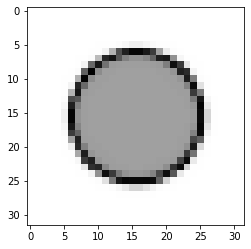

Label: 6


In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0,0,:,:].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [16]:
'''
def train_loop(train_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 128 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
'''

'\ndef train_loop(train_dataloader, model, loss_fn, optimizer):\n    size = len(dataloader.dataset)\n    for batch, (X, y) in enumerate(dataloader):\n        # Compute prediction and loss\n        pred = model(X)\n        loss = loss_fn(pred, y)\n\n        # Backpropagation\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        if batch % 128 == 0:\n            loss, current = loss.item(), batch * len(X)\n            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")\n'

In [17]:
def train_loop(device, epoch, train_loader, model, optimizer):
	model.train()
	# Iterate over batches
	for batch_idx, (X, y) in enumerate(train_loader):
		# Batch start time
		start_time = time.time()
		# Use sequence indices to slice corresponding images
		#x_seq = all_imgs[seq_ind,:,:]
		x_seq = X.float()       
		# Load data to device
		x_seq = x_seq.to(device)
		#y = torch.nn.functional.one_hot(y,num_classes=8)
		#print("y =",y)
		y = y.to(device)
		# Zero out gradients for optimizer 
		optimizer.zero_grad()
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		# Update model
		loss.backward()
		optimizer.step()
		# Batch duration
		end_time = time.time()
		batch_dur = end_time - start_time
		# Report prgoress
		#if batch_idx % args.log_interval == 0:
		if batch_idx % 10 == 0:
			# Accuracy
			acc = torch.eq(y_pred, y).float().mean().item() * 100.0
			# Report 	
			log.info('[Epoch: ' + str(epoch) + '] ' + \
					 '[Batch: ' + str(batch_idx) + ' of ' + str(len(train_loader)) + '] ' + \
					 '[Loss = ' + '{:.4f}'.format(loss.item()) + '] ' + \
					 '[Accuracy = ' + '{:.2f}'.format(acc) + '] ' + \
					 '[' + '{:.3f}'.format(batch_dur) + ' sec/batch]')
			# Save progress to file
			'''
			train_prog_f.write(str(batch_idx) + ' ' +\
							   '{:.4f}'.format(loss.item()) + ' ' + \
							   '{:.2f}'.format(acc) + '\n')
			'''

In [18]:
def test_loop_v2(device, epoch, test_loader, model):
	model.eval()
	# Iterate over batches
	for batch_idx, (X, y) in enumerate(test_loader):
		# Batch start time
		start_time = time.time()
		# Use sequence indices to slice corresponding images
		#x_seq = all_imgs[seq_ind,:,:]
		x_seq = X.float()       
		# Load data to device
		x_seq = x_seq.to(device)
		y = y.to(device)
		# Zero out gradients for optimizer 
		optimizer.zero_grad()
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		# Update model
		loss.backward()
		optimizer.step()
		# Batch duration
		end_time = time.time()
		batch_dur = end_time - start_time
		# Report prgoress
		#if batch_idx % args.log_interval == 0:
		if batch_idx % 10 == 0:
			# Accuracy
			acc = torch.eq(y_pred, y).float().mean().item() * 100.0
			# Report 	
			log.info('[Epoch: ' + str(epoch) + '] ' + \
					 '[Batch: ' + str(batch_idx) + ' of ' + str(len(train_loader)) + '] ' + \
					 '[Loss = ' + '{:.4f}'.format(loss.item()) + '] ' + \
					 '[Accuracy = ' + '{:.2f}'.format(acc) + '] ' + \
					 '[' + '{:.3f}'.format(batch_dur) + ' sec/batch]')
			# Save progress to file
			'''
			train_prog_f.write(str(batch_idx) + ' ' +\
							   '{:.4f}'.format(loss.item()) + ' ' + \
							   '{:.2f}'.format(acc) + '\n')
			'''

In [19]:
def test_loop(device, epoch, test_loader, model):
	log.info('Evaluating on test set...')
	# Set to eval mode
	model.eval()
	# Iterate over batches
	all_acc = []
	all_loss = []
	for batch_idx, (X, y) in enumerate(test_loader):
		# Use sequence indices to slice corresponding images
		x_seq = X.float()
		# Load data to device
		x_seq = x_seq.to(device)
		y = y.to(device)
		# Run model 
		'''
		if 'MNM' in args.model_name:
			y_pred_linear, y_pred, const_loss = model(x_seq, device)
		else:
			y_pred_linear, y_pred = model(x_seq, device)
		'''
		y_pred_linear, y_pred = model(x_seq, device)
		# Loss
		loss_fn = nn.CrossEntropyLoss()
		loss = loss_fn(y_pred_linear, y)
		'''
		if 'MNM' in args.model_name:
			loss += const_loss
		'''
		all_loss.append(loss.item())
		# Accuracy
		acc = torch.eq(y_pred, y).float().mean().item() * 100.0
		all_acc.append(acc)
		# Report progress
		log.info('[Batch: ' + str(batch_idx) + ' of ' + str(len(test_loader)) + ']')
	# Report overall test performance
	avg_loss = np.mean(all_loss)
	avg_acc = np.mean(all_acc)
	log.info('[Summary] ' + \
			 '[Loss = ' + '{:.4f}'.format(avg_loss) + '] ' + \
			 '[Accuracy = ' + '{:.2f}'.format(avg_acc) + ']')

In [20]:
learning_rate = 5e-4
batch_size = 32
epochs = 100
device = torch.device("cuda:" + str(0))
model = Model().to(device)
# Initialize the loss function
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(device, t+1, train_dataloader, model, optimizer)
test_loop(device,t, test_dataloader, model)
print("Done!")

[2021-05-20 01:22:29,428] Building encoder...
[2021-05-20 01:22:29,428] Building convolutional encoder...
[2021-05-20 01:22:29,429] Conv layers...
[2021-05-20 01:22:29,430] FC layers...
[2021-05-20 01:22:29,432] Building LSTM and output layers...
[2021-05-20 01:22:31,657] [Epoch: 1] [Batch: 0 of 157] [Loss = 2.0736] [Accuracy = 18.75] [0.053 sec/batch]


Epoch 1
-------------------------------


[2021-05-20 01:22:32,067] [Epoch: 1] [Batch: 10 of 157] [Loss = 2.1088] [Accuracy = 12.50] [0.041 sec/batch]
[2021-05-20 01:22:32,468] [Epoch: 1] [Batch: 20 of 157] [Loss = 2.0874] [Accuracy = 6.25] [0.039 sec/batch]
[2021-05-20 01:22:32,860] [Epoch: 1] [Batch: 30 of 157] [Loss = 2.0798] [Accuracy = 12.50] [0.039 sec/batch]
[2021-05-20 01:22:33,260] [Epoch: 1] [Batch: 40 of 157] [Loss = 2.0801] [Accuracy = 6.25] [0.040 sec/batch]
[2021-05-20 01:22:33,658] [Epoch: 1] [Batch: 50 of 157] [Loss = 2.0706] [Accuracy = 18.75] [0.038 sec/batch]
[2021-05-20 01:22:34,059] [Epoch: 1] [Batch: 60 of 157] [Loss = 2.0946] [Accuracy = 18.75] [0.038 sec/batch]
[2021-05-20 01:22:34,447] [Epoch: 1] [Batch: 70 of 157] [Loss = 2.0755] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:22:34,873] [Epoch: 1] [Batch: 80 of 157] [Loss = 2.0554] [Accuracy = 15.62] [0.044 sec/batch]
[2021-05-20 01:22:35,314] [Epoch: 1] [Batch: 90 of 157] [Loss = 2.0862] [Accuracy = 18.75] [0.045 sec/batch]
[2021-05-20 01:22:35,

Epoch 2
-------------------------------


[2021-05-20 01:22:38,490] [Epoch: 2] [Batch: 10 of 157] [Loss = 2.0772] [Accuracy = 18.75] [0.038 sec/batch]
[2021-05-20 01:22:38,899] [Epoch: 2] [Batch: 20 of 157] [Loss = 2.0819] [Accuracy = 9.38] [0.042 sec/batch]
[2021-05-20 01:22:39,304] [Epoch: 2] [Batch: 30 of 157] [Loss = 2.0709] [Accuracy = 28.12] [0.040 sec/batch]
[2021-05-20 01:22:39,707] [Epoch: 2] [Batch: 40 of 157] [Loss = 2.0720] [Accuracy = 12.50] [0.038 sec/batch]
[2021-05-20 01:22:40,112] [Epoch: 2] [Batch: 50 of 157] [Loss = 2.0953] [Accuracy = 12.50] [0.040 sec/batch]
[2021-05-20 01:22:40,526] [Epoch: 2] [Batch: 60 of 157] [Loss = 2.0808] [Accuracy = 15.62] [0.040 sec/batch]
[2021-05-20 01:22:40,936] [Epoch: 2] [Batch: 70 of 157] [Loss = 2.0677] [Accuracy = 12.50] [0.039 sec/batch]
[2021-05-20 01:22:41,345] [Epoch: 2] [Batch: 80 of 157] [Loss = 2.0568] [Accuracy = 15.62] [0.037 sec/batch]
[2021-05-20 01:22:41,751] [Epoch: 2] [Batch: 90 of 157] [Loss = 2.0816] [Accuracy = 9.38] [0.038 sec/batch]
[2021-05-20 01:22:42,

Epoch 3
-------------------------------


[2021-05-20 01:22:44,991] [Epoch: 3] [Batch: 10 of 157] [Loss = 2.0155] [Accuracy = 25.00] [0.045 sec/batch]
[2021-05-20 01:22:45,415] [Epoch: 3] [Batch: 20 of 157] [Loss = 2.0624] [Accuracy = 12.50] [0.040 sec/batch]
[2021-05-20 01:22:45,827] [Epoch: 3] [Batch: 30 of 157] [Loss = 2.0869] [Accuracy = 15.62] [0.041 sec/batch]
[2021-05-20 01:22:46,239] [Epoch: 3] [Batch: 40 of 157] [Loss = 2.0918] [Accuracy = 9.38] [0.040 sec/batch]
[2021-05-20 01:22:46,659] [Epoch: 3] [Batch: 50 of 157] [Loss = 2.1046] [Accuracy = 6.25] [0.040 sec/batch]
[2021-05-20 01:22:47,089] [Epoch: 3] [Batch: 60 of 157] [Loss = 2.0747] [Accuracy = 18.75] [0.038 sec/batch]
[2021-05-20 01:22:47,503] [Epoch: 3] [Batch: 70 of 157] [Loss = 2.0706] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:22:47,923] [Epoch: 3] [Batch: 80 of 157] [Loss = 2.0867] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:22:48,335] [Epoch: 3] [Batch: 90 of 157] [Loss = 2.0838] [Accuracy = 12.50] [0.040 sec/batch]
[2021-05-20 01:22:48,

Epoch 4
-------------------------------


[2021-05-20 01:22:51,600] [Epoch: 4] [Batch: 10 of 157] [Loss = 2.0990] [Accuracy = 12.50] [0.041 sec/batch]
[2021-05-20 01:22:52,019] [Epoch: 4] [Batch: 20 of 157] [Loss = 2.0772] [Accuracy = 12.50] [0.040 sec/batch]
[2021-05-20 01:22:52,443] [Epoch: 4] [Batch: 30 of 157] [Loss = 2.0727] [Accuracy = 12.50] [0.038 sec/batch]
[2021-05-20 01:22:52,863] [Epoch: 4] [Batch: 40 of 157] [Loss = 2.0454] [Accuracy = 15.62] [0.039 sec/batch]
[2021-05-20 01:22:53,274] [Epoch: 4] [Batch: 50 of 157] [Loss = 2.0816] [Accuracy = 9.38] [0.037 sec/batch]
[2021-05-20 01:22:53,697] [Epoch: 4] [Batch: 60 of 157] [Loss = 2.0136] [Accuracy = 15.62] [0.040 sec/batch]
[2021-05-20 01:22:54,120] [Epoch: 4] [Batch: 70 of 157] [Loss = 2.0507] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:22:54,547] [Epoch: 4] [Batch: 80 of 157] [Loss = 2.0881] [Accuracy = 18.75] [0.041 sec/batch]
[2021-05-20 01:22:54,969] [Epoch: 4] [Batch: 90 of 157] [Loss = 2.0127] [Accuracy = 31.25] [0.039 sec/batch]
[2021-05-20 01:22:55

Epoch 5
-------------------------------


[2021-05-20 01:22:58,332] [Epoch: 5] [Batch: 10 of 157] [Loss = 2.0066] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:22:58,793] [Epoch: 5] [Batch: 20 of 157] [Loss = 2.0463] [Accuracy = 12.50] [0.044 sec/batch]
[2021-05-20 01:22:59,212] [Epoch: 5] [Batch: 30 of 157] [Loss = 1.9698] [Accuracy = 37.50] [0.040 sec/batch]
[2021-05-20 01:22:59,633] [Epoch: 5] [Batch: 40 of 157] [Loss = 2.1159] [Accuracy = 12.50] [0.042 sec/batch]
[2021-05-20 01:23:00,055] [Epoch: 5] [Batch: 50 of 157] [Loss = 1.9859] [Accuracy = 18.75] [0.042 sec/batch]
[2021-05-20 01:23:00,479] [Epoch: 5] [Batch: 60 of 157] [Loss = 2.0199] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:23:00,832] [Epoch: 5] [Batch: 70 of 157] [Loss = 2.0287] [Accuracy = 18.75] [0.035 sec/batch]
[2021-05-20 01:23:01,189] [Epoch: 5] [Batch: 80 of 157] [Loss = 2.0624] [Accuracy = 15.62] [0.034 sec/batch]
[2021-05-20 01:23:01,540] [Epoch: 5] [Batch: 90 of 157] [Loss = 2.0434] [Accuracy = 18.75] [0.034 sec/batch]
[2021-05-20 01:23:0

Epoch 6
-------------------------------


[2021-05-20 01:23:04,330] [Epoch: 6] [Batch: 10 of 157] [Loss = 2.0167] [Accuracy = 12.50] [0.038 sec/batch]
[2021-05-20 01:23:04,727] [Epoch: 6] [Batch: 20 of 157] [Loss = 2.0087] [Accuracy = 18.75] [0.039 sec/batch]
[2021-05-20 01:23:05,126] [Epoch: 6] [Batch: 30 of 157] [Loss = 2.0101] [Accuracy = 18.75] [0.040 sec/batch]
[2021-05-20 01:23:05,534] [Epoch: 6] [Batch: 40 of 157] [Loss = 2.0060] [Accuracy = 18.75] [0.041 sec/batch]
[2021-05-20 01:23:05,939] [Epoch: 6] [Batch: 50 of 157] [Loss = 2.0212] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:23:06,333] [Epoch: 6] [Batch: 60 of 157] [Loss = 2.0456] [Accuracy = 18.75] [0.037 sec/batch]
[2021-05-20 01:23:06,738] [Epoch: 6] [Batch: 70 of 157] [Loss = 2.0121] [Accuracy = 12.50] [0.039 sec/batch]
[2021-05-20 01:23:07,134] [Epoch: 6] [Batch: 80 of 157] [Loss = 2.0225] [Accuracy = 18.75] [0.040 sec/batch]
[2021-05-20 01:23:07,554] [Epoch: 6] [Batch: 90 of 157] [Loss = 2.0440] [Accuracy = 6.25] [0.044 sec/batch]
[2021-05-20 01:23:07

Epoch 7
-------------------------------


[2021-05-20 01:23:10,862] [Epoch: 7] [Batch: 10 of 157] [Loss = 2.0187] [Accuracy = 21.88] [0.044 sec/batch]
[2021-05-20 01:23:11,276] [Epoch: 7] [Batch: 20 of 157] [Loss = 1.9266] [Accuracy = 28.12] [0.043 sec/batch]
[2021-05-20 01:23:11,690] [Epoch: 7] [Batch: 30 of 157] [Loss = 2.0404] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:23:12,110] [Epoch: 7] [Batch: 40 of 157] [Loss = 1.9465] [Accuracy = 21.88] [0.039 sec/batch]
[2021-05-20 01:23:12,534] [Epoch: 7] [Batch: 50 of 157] [Loss = 2.0178] [Accuracy = 9.38] [0.039 sec/batch]
[2021-05-20 01:23:12,952] [Epoch: 7] [Batch: 60 of 157] [Loss = 1.9969] [Accuracy = 28.12] [0.039 sec/batch]
[2021-05-20 01:23:13,371] [Epoch: 7] [Batch: 70 of 157] [Loss = 2.0109] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:23:13,786] [Epoch: 7] [Batch: 80 of 157] [Loss = 1.9980] [Accuracy = 15.62] [0.044 sec/batch]
[2021-05-20 01:23:14,196] [Epoch: 7] [Batch: 90 of 157] [Loss = 2.1841] [Accuracy = 3.12] [0.037 sec/batch]
[2021-05-20 01:23:14,

Epoch 8
-------------------------------


[2021-05-20 01:23:17,423] [Epoch: 8] [Batch: 10 of 157] [Loss = 2.0733] [Accuracy = 12.50] [0.041 sec/batch]
[2021-05-20 01:23:17,840] [Epoch: 8] [Batch: 20 of 157] [Loss = 1.9599] [Accuracy = 12.50] [0.039 sec/batch]
[2021-05-20 01:23:18,253] [Epoch: 8] [Batch: 30 of 157] [Loss = 2.0597] [Accuracy = 15.62] [0.042 sec/batch]
[2021-05-20 01:23:18,677] [Epoch: 8] [Batch: 40 of 157] [Loss = 1.9868] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:23:19,109] [Epoch: 8] [Batch: 50 of 157] [Loss = 1.8892] [Accuracy = 25.00] [0.044 sec/batch]
[2021-05-20 01:23:19,522] [Epoch: 8] [Batch: 60 of 157] [Loss = 1.9977] [Accuracy = 31.25] [0.042 sec/batch]
[2021-05-20 01:23:19,938] [Epoch: 8] [Batch: 70 of 157] [Loss = 2.1570] [Accuracy = 18.75] [0.042 sec/batch]
[2021-05-20 01:23:20,370] [Epoch: 8] [Batch: 80 of 157] [Loss = 1.9986] [Accuracy = 21.88] [0.042 sec/batch]
[2021-05-20 01:23:20,794] [Epoch: 8] [Batch: 90 of 157] [Loss = 1.9363] [Accuracy = 25.00] [0.042 sec/batch]
[2021-05-20 01:23:2

Epoch 9
-------------------------------


[2021-05-20 01:23:24,041] [Epoch: 9] [Batch: 10 of 157] [Loss = 1.8744] [Accuracy = 21.88] [0.043 sec/batch]
[2021-05-20 01:23:24,472] [Epoch: 9] [Batch: 20 of 157] [Loss = 1.7908] [Accuracy = 25.00] [0.041 sec/batch]
[2021-05-20 01:23:24,898] [Epoch: 9] [Batch: 30 of 157] [Loss = 1.9873] [Accuracy = 25.00] [0.040 sec/batch]
[2021-05-20 01:23:25,292] [Epoch: 9] [Batch: 40 of 157] [Loss = 1.9203] [Accuracy = 28.12] [0.037 sec/batch]
[2021-05-20 01:23:25,694] [Epoch: 9] [Batch: 50 of 157] [Loss = 1.8356] [Accuracy = 25.00] [0.041 sec/batch]
[2021-05-20 01:23:26,108] [Epoch: 9] [Batch: 60 of 157] [Loss = 1.9098] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:23:26,528] [Epoch: 9] [Batch: 70 of 157] [Loss = 1.9536] [Accuracy = 18.75] [0.039 sec/batch]
[2021-05-20 01:23:26,953] [Epoch: 9] [Batch: 80 of 157] [Loss = 2.0402] [Accuracy = 12.50] [0.041 sec/batch]
[2021-05-20 01:23:27,365] [Epoch: 9] [Batch: 90 of 157] [Loss = 1.9048] [Accuracy = 12.50] [0.041 sec/batch]
[2021-05-20 01:23:2

Epoch 10
-------------------------------


[2021-05-20 01:23:30,523] [Epoch: 10] [Batch: 10 of 157] [Loss = 1.8625] [Accuracy = 28.12] [0.040 sec/batch]
[2021-05-20 01:23:30,930] [Epoch: 10] [Batch: 20 of 157] [Loss = 1.8521] [Accuracy = 18.75] [0.037 sec/batch]
[2021-05-20 01:23:31,334] [Epoch: 10] [Batch: 30 of 157] [Loss = 1.9099] [Accuracy = 25.00] [0.041 sec/batch]
[2021-05-20 01:23:31,752] [Epoch: 10] [Batch: 40 of 157] [Loss = 1.8693] [Accuracy = 18.75] [0.040 sec/batch]
[2021-05-20 01:23:32,157] [Epoch: 10] [Batch: 50 of 157] [Loss = 1.9733] [Accuracy = 21.88] [0.041 sec/batch]
[2021-05-20 01:23:32,555] [Epoch: 10] [Batch: 60 of 157] [Loss = 1.9572] [Accuracy = 25.00] [0.039 sec/batch]
[2021-05-20 01:23:32,955] [Epoch: 10] [Batch: 70 of 157] [Loss = 2.0302] [Accuracy = 18.75] [0.038 sec/batch]
[2021-05-20 01:23:33,359] [Epoch: 10] [Batch: 80 of 157] [Loss = 1.9693] [Accuracy = 21.88] [0.040 sec/batch]
[2021-05-20 01:23:33,757] [Epoch: 10] [Batch: 90 of 157] [Loss = 1.9155] [Accuracy = 37.50] [0.036 sec/batch]
[2021-05-2

Epoch 11
-------------------------------


[2021-05-20 01:23:36,896] [Epoch: 11] [Batch: 10 of 157] [Loss = 2.0085] [Accuracy = 18.75] [0.040 sec/batch]
[2021-05-20 01:23:37,298] [Epoch: 11] [Batch: 20 of 157] [Loss = 1.8183] [Accuracy = 25.00] [0.038 sec/batch]
[2021-05-20 01:23:37,709] [Epoch: 11] [Batch: 30 of 157] [Loss = 1.9415] [Accuracy = 28.12] [0.041 sec/batch]
[2021-05-20 01:23:38,117] [Epoch: 11] [Batch: 40 of 157] [Loss = 2.0953] [Accuracy = 9.38] [0.041 sec/batch]
[2021-05-20 01:23:38,518] [Epoch: 11] [Batch: 50 of 157] [Loss = 1.8563] [Accuracy = 28.12] [0.040 sec/batch]
[2021-05-20 01:23:38,910] [Epoch: 11] [Batch: 60 of 157] [Loss = 1.9668] [Accuracy = 25.00] [0.038 sec/batch]
[2021-05-20 01:23:39,306] [Epoch: 11] [Batch: 70 of 157] [Loss = 1.8386] [Accuracy = 25.00] [0.042 sec/batch]
[2021-05-20 01:23:39,717] [Epoch: 11] [Batch: 80 of 157] [Loss = 1.9849] [Accuracy = 21.88] [0.041 sec/batch]
[2021-05-20 01:23:40,116] [Epoch: 11] [Batch: 90 of 157] [Loss = 1.9934] [Accuracy = 34.38] [0.040 sec/batch]
[2021-05-20

Epoch 12
-------------------------------


[2021-05-20 01:23:43,220] [Epoch: 12] [Batch: 10 of 157] [Loss = 1.8375] [Accuracy = 28.12] [0.041 sec/batch]
[2021-05-20 01:23:43,608] [Epoch: 12] [Batch: 20 of 157] [Loss = 1.8858] [Accuracy = 21.88] [0.034 sec/batch]
[2021-05-20 01:23:44,007] [Epoch: 12] [Batch: 30 of 157] [Loss = 1.7672] [Accuracy = 15.62] [0.040 sec/batch]
[2021-05-20 01:23:44,418] [Epoch: 12] [Batch: 40 of 157] [Loss = 1.8607] [Accuracy = 21.88] [0.043 sec/batch]
[2021-05-20 01:23:44,811] [Epoch: 12] [Batch: 50 of 157] [Loss = 1.9306] [Accuracy = 21.88] [0.036 sec/batch]
[2021-05-20 01:23:45,214] [Epoch: 12] [Batch: 60 of 157] [Loss = 1.6495] [Accuracy = 59.38] [0.038 sec/batch]
[2021-05-20 01:23:45,614] [Epoch: 12] [Batch: 70 of 157] [Loss = 1.6744] [Accuracy = 43.75] [0.038 sec/batch]
[2021-05-20 01:23:46,014] [Epoch: 12] [Batch: 80 of 157] [Loss = 2.0186] [Accuracy = 28.12] [0.038 sec/batch]
[2021-05-20 01:23:46,404] [Epoch: 12] [Batch: 90 of 157] [Loss = 2.0540] [Accuracy = 21.88] [0.034 sec/batch]
[2021-05-2

Epoch 13
-------------------------------


[2021-05-20 01:23:49,571] [Epoch: 13] [Batch: 10 of 157] [Loss = 1.7164] [Accuracy = 34.38] [0.041 sec/batch]
[2021-05-20 01:23:49,975] [Epoch: 13] [Batch: 20 of 157] [Loss = 1.7527] [Accuracy = 34.38] [0.038 sec/batch]
[2021-05-20 01:23:50,383] [Epoch: 13] [Batch: 30 of 157] [Loss = 1.7292] [Accuracy = 37.50] [0.039 sec/batch]
[2021-05-20 01:23:50,795] [Epoch: 13] [Batch: 40 of 157] [Loss = 1.8013] [Accuracy = 31.25] [0.042 sec/batch]
[2021-05-20 01:23:51,227] [Epoch: 13] [Batch: 50 of 157] [Loss = 1.9388] [Accuracy = 21.88] [0.042 sec/batch]
[2021-05-20 01:23:51,636] [Epoch: 13] [Batch: 60 of 157] [Loss = 1.9475] [Accuracy = 15.62] [0.043 sec/batch]
[2021-05-20 01:23:52,034] [Epoch: 13] [Batch: 70 of 157] [Loss = 1.8145] [Accuracy = 34.38] [0.042 sec/batch]
[2021-05-20 01:23:52,451] [Epoch: 13] [Batch: 80 of 157] [Loss = 1.8710] [Accuracy = 25.00] [0.041 sec/batch]
[2021-05-20 01:23:52,865] [Epoch: 13] [Batch: 90 of 157] [Loss = 1.7956] [Accuracy = 28.12] [0.039 sec/batch]
[2021-05-2

Epoch 14
-------------------------------


[2021-05-20 01:23:56,064] [Epoch: 14] [Batch: 10 of 157] [Loss = 1.6612] [Accuracy = 34.38] [0.039 sec/batch]
[2021-05-20 01:23:56,476] [Epoch: 14] [Batch: 20 of 157] [Loss = 1.6628] [Accuracy = 43.75] [0.043 sec/batch]
[2021-05-20 01:23:56,891] [Epoch: 14] [Batch: 30 of 157] [Loss = 1.7969] [Accuracy = 25.00] [0.043 sec/batch]
[2021-05-20 01:23:57,293] [Epoch: 14] [Batch: 40 of 157] [Loss = 1.8132] [Accuracy = 40.62] [0.040 sec/batch]
[2021-05-20 01:23:57,696] [Epoch: 14] [Batch: 50 of 157] [Loss = 1.4983] [Accuracy = 50.00] [0.043 sec/batch]
[2021-05-20 01:23:58,096] [Epoch: 14] [Batch: 60 of 157] [Loss = 1.8038] [Accuracy = 40.62] [0.038 sec/batch]
[2021-05-20 01:23:58,486] [Epoch: 14] [Batch: 70 of 157] [Loss = 1.5186] [Accuracy = 53.12] [0.039 sec/batch]
[2021-05-20 01:23:58,890] [Epoch: 14] [Batch: 80 of 157] [Loss = 1.8157] [Accuracy = 34.38] [0.042 sec/batch]
[2021-05-20 01:23:59,283] [Epoch: 14] [Batch: 90 of 157] [Loss = 1.6856] [Accuracy = 37.50] [0.040 sec/batch]
[2021-05-2

Epoch 15
-------------------------------


[2021-05-20 01:24:02,404] [Epoch: 15] [Batch: 10 of 157] [Loss = 1.5296] [Accuracy = 40.62] [0.043 sec/batch]
[2021-05-20 01:24:02,821] [Epoch: 15] [Batch: 20 of 157] [Loss = 1.3840] [Accuracy = 43.75] [0.044 sec/batch]
[2021-05-20 01:24:03,236] [Epoch: 15] [Batch: 30 of 157] [Loss = 1.5860] [Accuracy = 31.25] [0.040 sec/batch]
[2021-05-20 01:24:03,661] [Epoch: 15] [Batch: 40 of 157] [Loss = 1.4470] [Accuracy = 43.75] [0.040 sec/batch]
[2021-05-20 01:24:04,078] [Epoch: 15] [Batch: 50 of 157] [Loss = 1.3184] [Accuracy = 59.38] [0.035 sec/batch]
[2021-05-20 01:24:04,486] [Epoch: 15] [Batch: 60 of 157] [Loss = 1.6498] [Accuracy = 37.50] [0.044 sec/batch]
[2021-05-20 01:24:04,876] [Epoch: 15] [Batch: 70 of 157] [Loss = 1.6604] [Accuracy = 40.62] [0.034 sec/batch]
[2021-05-20 01:24:05,246] [Epoch: 15] [Batch: 80 of 157] [Loss = 1.5749] [Accuracy = 31.25] [0.038 sec/batch]
[2021-05-20 01:24:05,648] [Epoch: 15] [Batch: 90 of 157] [Loss = 1.6342] [Accuracy = 40.62] [0.042 sec/batch]
[2021-05-2

Epoch 16
-------------------------------


[2021-05-20 01:24:08,763] [Epoch: 16] [Batch: 10 of 157] [Loss = 1.3027] [Accuracy = 65.62] [0.036 sec/batch]
[2021-05-20 01:24:09,188] [Epoch: 16] [Batch: 20 of 157] [Loss = 1.2646] [Accuracy = 68.75] [0.042 sec/batch]
[2021-05-20 01:24:09,594] [Epoch: 16] [Batch: 30 of 157] [Loss = 1.7297] [Accuracy = 40.62] [0.038 sec/batch]
[2021-05-20 01:24:10,000] [Epoch: 16] [Batch: 40 of 157] [Loss = 1.2456] [Accuracy = 56.25] [0.039 sec/batch]
[2021-05-20 01:24:10,399] [Epoch: 16] [Batch: 50 of 157] [Loss = 1.4220] [Accuracy = 50.00] [0.039 sec/batch]
[2021-05-20 01:24:10,807] [Epoch: 16] [Batch: 60 of 157] [Loss = 1.4034] [Accuracy = 53.12] [0.042 sec/batch]
[2021-05-20 01:24:11,212] [Epoch: 16] [Batch: 70 of 157] [Loss = 1.4846] [Accuracy = 50.00] [0.040 sec/batch]
[2021-05-20 01:24:11,630] [Epoch: 16] [Batch: 80 of 157] [Loss = 1.2623] [Accuracy = 59.38] [0.041 sec/batch]
[2021-05-20 01:24:12,032] [Epoch: 16] [Batch: 90 of 157] [Loss = 1.4680] [Accuracy = 37.50] [0.040 sec/batch]
[2021-05-2

Epoch 17
-------------------------------


[2021-05-20 01:24:15,218] [Epoch: 17] [Batch: 10 of 157] [Loss = 0.9106] [Accuracy = 71.88] [0.042 sec/batch]
[2021-05-20 01:24:15,646] [Epoch: 17] [Batch: 20 of 157] [Loss = 0.9285] [Accuracy = 71.88] [0.043 sec/batch]
[2021-05-20 01:24:16,068] [Epoch: 17] [Batch: 30 of 157] [Loss = 0.8499] [Accuracy = 78.12] [0.039 sec/batch]
[2021-05-20 01:24:16,490] [Epoch: 17] [Batch: 40 of 157] [Loss = 1.3818] [Accuracy = 46.88] [0.043 sec/batch]
[2021-05-20 01:24:16,913] [Epoch: 17] [Batch: 50 of 157] [Loss = 1.1817] [Accuracy = 56.25] [0.044 sec/batch]
[2021-05-20 01:24:17,340] [Epoch: 17] [Batch: 60 of 157] [Loss = 1.0694] [Accuracy = 65.62] [0.041 sec/batch]
[2021-05-20 01:24:17,775] [Epoch: 17] [Batch: 70 of 157] [Loss = 1.1598] [Accuracy = 56.25] [0.039 sec/batch]
[2021-05-20 01:24:18,200] [Epoch: 17] [Batch: 80 of 157] [Loss = 1.0699] [Accuracy = 59.38] [0.042 sec/batch]
[2021-05-20 01:24:18,634] [Epoch: 17] [Batch: 90 of 157] [Loss = 1.1876] [Accuracy = 59.38] [0.049 sec/batch]
[2021-05-2

Epoch 18
-------------------------------


[2021-05-20 01:24:21,908] [Epoch: 18] [Batch: 10 of 157] [Loss = 0.8345] [Accuracy = 68.75] [0.040 sec/batch]
[2021-05-20 01:24:22,326] [Epoch: 18] [Batch: 20 of 157] [Loss = 0.6896] [Accuracy = 81.25] [0.042 sec/batch]
[2021-05-20 01:24:22,750] [Epoch: 18] [Batch: 30 of 157] [Loss = 0.6417] [Accuracy = 78.12] [0.040 sec/batch]
[2021-05-20 01:24:23,176] [Epoch: 18] [Batch: 40 of 157] [Loss = 0.6236] [Accuracy = 93.75] [0.040 sec/batch]
[2021-05-20 01:24:23,590] [Epoch: 18] [Batch: 50 of 157] [Loss = 0.6932] [Accuracy = 81.25] [0.038 sec/batch]
[2021-05-20 01:24:24,006] [Epoch: 18] [Batch: 60 of 157] [Loss = 0.6389] [Accuracy = 81.25] [0.038 sec/batch]
[2021-05-20 01:24:24,425] [Epoch: 18] [Batch: 70 of 157] [Loss = 0.7610] [Accuracy = 71.88] [0.043 sec/batch]
[2021-05-20 01:24:24,843] [Epoch: 18] [Batch: 80 of 157] [Loss = 0.6115] [Accuracy = 87.50] [0.040 sec/batch]
[2021-05-20 01:24:25,256] [Epoch: 18] [Batch: 90 of 157] [Loss = 0.4413] [Accuracy = 96.88] [0.040 sec/batch]
[2021-05-2

Epoch 19
-------------------------------


[2021-05-20 01:24:28,459] [Epoch: 19] [Batch: 10 of 157] [Loss = 0.2790] [Accuracy = 96.88] [0.040 sec/batch]
[2021-05-20 01:24:28,857] [Epoch: 19] [Batch: 20 of 157] [Loss = 0.4209] [Accuracy = 90.62] [0.033 sec/batch]
[2021-05-20 01:24:29,269] [Epoch: 19] [Batch: 30 of 157] [Loss = 0.4302] [Accuracy = 87.50] [0.043 sec/batch]
[2021-05-20 01:24:29,679] [Epoch: 19] [Batch: 40 of 157] [Loss = 0.4008] [Accuracy = 93.75] [0.039 sec/batch]
[2021-05-20 01:24:30,072] [Epoch: 19] [Batch: 50 of 157] [Loss = 0.3700] [Accuracy = 96.88] [0.034 sec/batch]
[2021-05-20 01:24:30,480] [Epoch: 19] [Batch: 60 of 157] [Loss = 0.3162] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:24:30,904] [Epoch: 19] [Batch: 70 of 157] [Loss = 0.4551] [Accuracy = 84.38] [0.041 sec/batch]
[2021-05-20 01:24:31,315] [Epoch: 19] [Batch: 80 of 157] [Loss = 0.3316] [Accuracy = 93.75] [0.040 sec/batch]
[2021-05-20 01:24:31,743] [Epoch: 19] [Batch: 90 of 157] [Loss = 0.3240] [Accuracy = 96.88] [0.040 sec/batch]
[2021-05-

Epoch 20
-------------------------------


[2021-05-20 01:24:35,014] [Epoch: 20] [Batch: 10 of 157] [Loss = 0.2451] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:24:35,438] [Epoch: 20] [Batch: 20 of 157] [Loss = 0.1633] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:24:35,867] [Epoch: 20] [Batch: 30 of 157] [Loss = 0.2327] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:24:36,284] [Epoch: 20] [Batch: 40 of 157] [Loss = 0.2622] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:36,712] [Epoch: 20] [Batch: 50 of 157] [Loss = 0.2718] [Accuracy = 96.88] [0.039 sec/batch]
[2021-05-20 01:24:37,138] [Epoch: 20] [Batch: 60 of 157] [Loss = 0.2437] [Accuracy = 93.75] [0.041 sec/batch]
[2021-05-20 01:24:37,562] [Epoch: 20] [Batch: 70 of 157] [Loss = 0.1919] [Accuracy = 96.88] [0.039 sec/batch]
[2021-05-20 01:24:37,965] [Epoch: 20] [Batch: 80 of 157] [Loss = 0.1226] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:24:38,366] [Epoch: 20] [Batch: 90 of 157] [Loss = 0.1423] [Accuracy = 100.00] [0.039 sec/batch]
[202

Epoch 21
-------------------------------


[2021-05-20 01:24:41,594] [Epoch: 21] [Batch: 10 of 157] [Loss = 0.0826] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:42,043] [Epoch: 21] [Batch: 20 of 157] [Loss = 0.0971] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:24:42,465] [Epoch: 21] [Batch: 30 of 157] [Loss = 0.0653] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:24:42,909] [Epoch: 21] [Batch: 40 of 157] [Loss = 0.0739] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:24:43,359] [Epoch: 21] [Batch: 50 of 157] [Loss = 0.0729] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:24:43,800] [Epoch: 21] [Batch: 60 of 157] [Loss = 0.0798] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:24:44,243] [Epoch: 21] [Batch: 70 of 157] [Loss = 0.1146] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:24:44,692] [Epoch: 21] [Batch: 80 of 157] [Loss = 0.0681] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:24:45,129] [Epoch: 21] [Batch: 90 of 157] [Loss = 0.0577] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 22
-------------------------------


[2021-05-20 01:24:48,477] [Epoch: 22] [Batch: 10 of 157] [Loss = 0.0405] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:24:48,904] [Epoch: 22] [Batch: 20 of 157] [Loss = 0.0472] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:49,336] [Epoch: 22] [Batch: 30 of 157] [Loss = 0.0449] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:24:49,755] [Epoch: 22] [Batch: 40 of 157] [Loss = 0.0445] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:24:50,176] [Epoch: 22] [Batch: 50 of 157] [Loss = 0.0318] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:24:50,595] [Epoch: 22] [Batch: 60 of 157] [Loss = 0.0488] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:24:51,020] [Epoch: 22] [Batch: 70 of 157] [Loss = 0.0395] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:51,426] [Epoch: 22] [Batch: 80 of 157] [Loss = 0.0401] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:24:51,847] [Epoch: 22] [Batch: 90 of 157] [Loss = 0.0443] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 23
-------------------------------


[2021-05-20 01:24:55,096] [Epoch: 23] [Batch: 10 of 157] [Loss = 0.0238] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:24:55,512] [Epoch: 23] [Batch: 20 of 157] [Loss = 0.0280] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:24:55,948] [Epoch: 23] [Batch: 30 of 157] [Loss = 0.0282] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:24:56,375] [Epoch: 23] [Batch: 40 of 157] [Loss = 0.0180] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:56,803] [Epoch: 23] [Batch: 50 of 157] [Loss = 0.0224] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:24:57,221] [Epoch: 23] [Batch: 60 of 157] [Loss = 0.0258] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:24:57,639] [Epoch: 23] [Batch: 70 of 157] [Loss = 0.0204] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:24:58,061] [Epoch: 23] [Batch: 80 of 157] [Loss = 0.0152] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:24:58,465] [Epoch: 23] [Batch: 90 of 157] [Loss = 0.0241] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 24
-------------------------------


[2021-05-20 01:25:01,808] [Epoch: 24] [Batch: 10 of 157] [Loss = 0.0199] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:02,233] [Epoch: 24] [Batch: 20 of 157] [Loss = 0.0163] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:02,673] [Epoch: 24] [Batch: 30 of 157] [Loss = 0.0171] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:03,110] [Epoch: 24] [Batch: 40 of 157] [Loss = 0.0189] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:03,553] [Epoch: 24] [Batch: 50 of 157] [Loss = 0.0239] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:03,964] [Epoch: 24] [Batch: 60 of 157] [Loss = 0.0159] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:04,396] [Epoch: 24] [Batch: 70 of 157] [Loss = 0.0189] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:04,831] [Epoch: 24] [Batch: 80 of 157] [Loss = 0.0162] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:25:05,267] [Epoch: 24] [Batch: 90 of 157] [Loss = 0.0214] [Accuracy = 100.00] [0.045 sec/batch]
[

Epoch 25
-------------------------------


[2021-05-20 01:25:08,567] [Epoch: 25] [Batch: 10 of 157] [Loss = 0.0115] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:09,005] [Epoch: 25] [Batch: 20 of 157] [Loss = 0.0095] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:09,420] [Epoch: 25] [Batch: 30 of 157] [Loss = 0.0125] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:09,829] [Epoch: 25] [Batch: 40 of 157] [Loss = 0.0092] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:10,245] [Epoch: 25] [Batch: 50 of 157] [Loss = 0.0122] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:10,655] [Epoch: 25] [Batch: 60 of 157] [Loss = 0.0147] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:25:11,077] [Epoch: 25] [Batch: 70 of 157] [Loss = 0.0129] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:25:11,517] [Epoch: 25] [Batch: 80 of 157] [Loss = 0.0120] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:25:11,955] [Epoch: 25] [Batch: 90 of 157] [Loss = 0.0147] [Accuracy = 100.00] [0.047 sec/batch]
[

Epoch 26
-------------------------------


[2021-05-20 01:25:15,264] [Epoch: 26] [Batch: 10 of 157] [Loss = 0.0106] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:15,680] [Epoch: 26] [Batch: 20 of 157] [Loss = 0.0110] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:16,082] [Epoch: 26] [Batch: 30 of 157] [Loss = 0.0083] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:16,470] [Epoch: 26] [Batch: 40 of 157] [Loss = 0.0065] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:16,873] [Epoch: 26] [Batch: 50 of 157] [Loss = 0.0061] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:17,268] [Epoch: 26] [Batch: 60 of 157] [Loss = 0.0092] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:17,686] [Epoch: 26] [Batch: 70 of 157] [Loss = 0.0086] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:18,098] [Epoch: 26] [Batch: 80 of 157] [Loss = 0.0102] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:18,517] [Epoch: 26] [Batch: 90 of 157] [Loss = 0.0097] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 27
-------------------------------


[2021-05-20 01:25:21,817] [Epoch: 27] [Batch: 10 of 157] [Loss = 0.0077] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:22,246] [Epoch: 27] [Batch: 20 of 157] [Loss = 0.0070] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:22,670] [Epoch: 27] [Batch: 30 of 157] [Loss = 0.0071] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:23,108] [Epoch: 27] [Batch: 40 of 157] [Loss = 0.0089] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:23,543] [Epoch: 27] [Batch: 50 of 157] [Loss = 0.0074] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:23,979] [Epoch: 27] [Batch: 60 of 157] [Loss = 0.0078] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:24,411] [Epoch: 27] [Batch: 70 of 157] [Loss = 0.0077] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:24,823] [Epoch: 27] [Batch: 80 of 157] [Loss = 0.0099] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:25:25,215] [Epoch: 27] [Batch: 90 of 157] [Loss = 0.0086] [Accuracy = 100.00] [0.035 sec/batch]
[

Epoch 28
-------------------------------


[2021-05-20 01:25:28,424] [Epoch: 28] [Batch: 10 of 157] [Loss = 0.0053] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:28,849] [Epoch: 28] [Batch: 20 of 157] [Loss = 0.0050] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:29,239] [Epoch: 28] [Batch: 30 of 157] [Loss = 0.0066] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:29,644] [Epoch: 28] [Batch: 40 of 157] [Loss = 0.0059] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:30,055] [Epoch: 28] [Batch: 50 of 157] [Loss = 0.0071] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:30,470] [Epoch: 28] [Batch: 60 of 157] [Loss = 0.0066] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:30,893] [Epoch: 28] [Batch: 70 of 157] [Loss = 0.0057] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:25:31,317] [Epoch: 28] [Batch: 80 of 157] [Loss = 0.0050] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:31,738] [Epoch: 28] [Batch: 90 of 157] [Loss = 0.0060] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 29
-------------------------------


[2021-05-20 01:25:35,005] [Epoch: 29] [Batch: 10 of 157] [Loss = 0.0048] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:35,440] [Epoch: 29] [Batch: 20 of 157] [Loss = 0.0059] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:35,872] [Epoch: 29] [Batch: 30 of 157] [Loss = 0.0044] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:36,294] [Epoch: 29] [Batch: 40 of 157] [Loss = 0.0053] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:36,721] [Epoch: 29] [Batch: 50 of 157] [Loss = 0.0049] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:37,137] [Epoch: 29] [Batch: 60 of 157] [Loss = 0.0056] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:37,511] [Epoch: 29] [Batch: 70 of 157] [Loss = 0.0050] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:25:37,916] [Epoch: 29] [Batch: 80 of 157] [Loss = 0.0075] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:38,328] [Epoch: 29] [Batch: 90 of 157] [Loss = 0.0055] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 30
-------------------------------


[2021-05-20 01:25:41,657] [Epoch: 30] [Batch: 10 of 157] [Loss = 0.0041] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:25:42,083] [Epoch: 30] [Batch: 20 of 157] [Loss = 0.0046] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:42,484] [Epoch: 30] [Batch: 30 of 157] [Loss = 0.0049] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:42,890] [Epoch: 30] [Batch: 40 of 157] [Loss = 0.0052] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:43,299] [Epoch: 30] [Batch: 50 of 157] [Loss = 0.0041] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:43,735] [Epoch: 30] [Batch: 60 of 157] [Loss = 0.0045] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:44,172] [Epoch: 30] [Batch: 70 of 157] [Loss = 0.0050] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:44,592] [Epoch: 30] [Batch: 80 of 157] [Loss = 0.0037] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:45,010] [Epoch: 30] [Batch: 90 of 157] [Loss = 0.0043] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 31
-------------------------------


[2021-05-20 01:25:48,233] [Epoch: 31] [Batch: 10 of 157] [Loss = 0.0035] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:48,644] [Epoch: 31] [Batch: 20 of 157] [Loss = 0.0032] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:49,040] [Epoch: 31] [Batch: 30 of 157] [Loss = 0.0035] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:25:49,469] [Epoch: 31] [Batch: 40 of 157] [Loss = 0.0029] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:49,901] [Epoch: 31] [Batch: 50 of 157] [Loss = 0.0031] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:25:50,315] [Epoch: 31] [Batch: 60 of 157] [Loss = 0.0032] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:50,726] [Epoch: 31] [Batch: 70 of 157] [Loss = 0.0038] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:51,154] [Epoch: 31] [Batch: 80 of 157] [Loss = 0.0036] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:51,562] [Epoch: 31] [Batch: 90 of 157] [Loss = 0.0048] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 32
-------------------------------


[2021-05-20 01:25:54,714] [Epoch: 32] [Batch: 10 of 157] [Loss = 0.0031] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:25:55,134] [Epoch: 32] [Batch: 20 of 157] [Loss = 0.0036] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:55,549] [Epoch: 32] [Batch: 30 of 157] [Loss = 0.0038] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:25:55,955] [Epoch: 32] [Batch: 40 of 157] [Loss = 0.0032] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:56,384] [Epoch: 32] [Batch: 50 of 157] [Loss = 0.0029] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:25:56,791] [Epoch: 32] [Batch: 60 of 157] [Loss = 0.0035] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:25:57,223] [Epoch: 32] [Batch: 70 of 157] [Loss = 0.0029] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:57,651] [Epoch: 32] [Batch: 80 of 157] [Loss = 0.0039] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:25:58,087] [Epoch: 32] [Batch: 90 of 157] [Loss = 0.0036] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 33
-------------------------------


[2021-05-20 01:26:01,312] [Epoch: 33] [Batch: 10 of 157] [Loss = 0.0030] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:01,725] [Epoch: 33] [Batch: 20 of 157] [Loss = 0.0025] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:02,143] [Epoch: 33] [Batch: 30 of 157] [Loss = 0.0023] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:26:02,567] [Epoch: 33] [Batch: 40 of 157] [Loss = 0.0027] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:03,000] [Epoch: 33] [Batch: 50 of 157] [Loss = 0.0028] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:03,400] [Epoch: 33] [Batch: 60 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:26:03,835] [Epoch: 33] [Batch: 70 of 157] [Loss = 0.0027] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:04,252] [Epoch: 33] [Batch: 80 of 157] [Loss = 0.0025] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:26:04,663] [Epoch: 33] [Batch: 90 of 157] [Loss = 0.0030] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 34
-------------------------------


[2021-05-20 01:26:07,992] [Epoch: 34] [Batch: 10 of 157] [Loss = 0.0025] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:08,396] [Epoch: 34] [Batch: 20 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:08,823] [Epoch: 34] [Batch: 30 of 157] [Loss = 0.0027] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:26:09,243] [Epoch: 34] [Batch: 40 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:09,671] [Epoch: 34] [Batch: 50 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:26:10,079] [Epoch: 34] [Batch: 60 of 157] [Loss = 0.0016] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:26:10,499] [Epoch: 34] [Batch: 70 of 157] [Loss = 0.0026] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:26:10,918] [Epoch: 34] [Batch: 80 of 157] [Loss = 0.0028] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:11,332] [Epoch: 34] [Batch: 90 of 157] [Loss = 0.0024] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 35
-------------------------------


[2021-05-20 01:26:14,527] [Epoch: 35] [Batch: 10 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:26:14,933] [Epoch: 35] [Batch: 20 of 157] [Loss = 0.0020] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:15,328] [Epoch: 35] [Batch: 30 of 157] [Loss = 0.0027] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:15,732] [Epoch: 35] [Batch: 40 of 157] [Loss = 0.0019] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:16,133] [Epoch: 35] [Batch: 50 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:26:16,527] [Epoch: 35] [Batch: 60 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:16,914] [Epoch: 35] [Batch: 70 of 157] [Loss = 0.0017] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:26:17,311] [Epoch: 35] [Batch: 80 of 157] [Loss = 0.0019] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:26:17,709] [Epoch: 35] [Batch: 90 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 36
-------------------------------


[2021-05-20 01:26:20,743] [Epoch: 36] [Batch: 10 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:21,147] [Epoch: 36] [Batch: 20 of 157] [Loss = 0.0016] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:21,548] [Epoch: 36] [Batch: 30 of 157] [Loss = 0.0018] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:21,928] [Epoch: 36] [Batch: 40 of 157] [Loss = 0.0020] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:22,330] [Epoch: 36] [Batch: 50 of 157] [Loss = 0.0014] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:22,727] [Epoch: 36] [Batch: 60 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:26:23,128] [Epoch: 36] [Batch: 70 of 157] [Loss = 0.0018] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:23,532] [Epoch: 36] [Batch: 80 of 157] [Loss = 0.0022] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:23,931] [Epoch: 36] [Batch: 90 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 37
-------------------------------


[2021-05-20 01:26:27,111] [Epoch: 37] [Batch: 10 of 157] [Loss = 0.0020] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:27,540] [Epoch: 37] [Batch: 20 of 157] [Loss = 0.0018] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:26:27,949] [Epoch: 37] [Batch: 30 of 157] [Loss = 0.0020] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:26:28,352] [Epoch: 37] [Batch: 40 of 157] [Loss = 0.0021] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:28,754] [Epoch: 37] [Batch: 50 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:29,174] [Epoch: 37] [Batch: 60 of 157] [Loss = 0.0020] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:29,590] [Epoch: 37] [Batch: 70 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:29,998] [Epoch: 37] [Batch: 80 of 157] [Loss = 0.0018] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:26:30,391] [Epoch: 37] [Batch: 90 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 38
-------------------------------


[2021-05-20 01:26:33,645] [Epoch: 38] [Batch: 10 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:34,079] [Epoch: 38] [Batch: 20 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:34,513] [Epoch: 38] [Batch: 30 of 157] [Loss = 0.0017] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:34,943] [Epoch: 38] [Batch: 40 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:35,390] [Epoch: 38] [Batch: 50 of 157] [Loss = 0.0016] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:26:35,824] [Epoch: 38] [Batch: 60 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:36,242] [Epoch: 38] [Batch: 70 of 157] [Loss = 0.0017] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:36,658] [Epoch: 38] [Batch: 80 of 157] [Loss = 0.0016] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:37,072] [Epoch: 38] [Batch: 90 of 157] [Loss = 0.0017] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 39
-------------------------------


[2021-05-20 01:26:40,390] [Epoch: 39] [Batch: 10 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:40,813] [Epoch: 39] [Batch: 20 of 157] [Loss = 0.0014] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:26:41,233] [Epoch: 39] [Batch: 30 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:26:41,653] [Epoch: 39] [Batch: 40 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:42,080] [Epoch: 39] [Batch: 50 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:42,508] [Epoch: 39] [Batch: 60 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:42,943] [Epoch: 39] [Batch: 70 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:26:43,364] [Epoch: 39] [Batch: 80 of 157] [Loss = 0.0015] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:43,786] [Epoch: 39] [Batch: 90 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 40
-------------------------------


[2021-05-20 01:26:47,075] [Epoch: 40] [Batch: 10 of 157] [Loss = 0.0014] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:26:47,496] [Epoch: 40] [Batch: 20 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:47,910] [Epoch: 40] [Batch: 30 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:48,319] [Epoch: 40] [Batch: 40 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:48,737] [Epoch: 40] [Batch: 50 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:49,166] [Epoch: 40] [Batch: 60 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:49,588] [Epoch: 40] [Batch: 70 of 157] [Loss = 0.0012] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:50,010] [Epoch: 40] [Batch: 80 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:50,436] [Epoch: 40] [Batch: 90 of 157] [Loss = 0.0013] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 41
-------------------------------


[2021-05-20 01:26:53,756] [Epoch: 41] [Batch: 10 of 157] [Loss = 0.0014] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:26:54,186] [Epoch: 41] [Batch: 20 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:54,611] [Epoch: 41] [Batch: 30 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:55,039] [Epoch: 41] [Batch: 40 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:26:55,459] [Epoch: 41] [Batch: 50 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:26:55,877] [Epoch: 41] [Batch: 60 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.035 sec/batch]
[2021-05-20 01:26:56,289] [Epoch: 41] [Batch: 70 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:26:56,710] [Epoch: 41] [Batch: 80 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:26:57,131] [Epoch: 41] [Batch: 90 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.043 sec/batch]
[

Epoch 42
-------------------------------


[2021-05-20 01:27:00,363] [Epoch: 42] [Batch: 10 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:00,768] [Epoch: 42] [Batch: 20 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:01,174] [Epoch: 42] [Batch: 30 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:01,583] [Epoch: 42] [Batch: 40 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:02,003] [Epoch: 42] [Batch: 50 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:02,408] [Epoch: 42] [Batch: 60 of 157] [Loss = 0.0011] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:02,829] [Epoch: 42] [Batch: 70 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:03,241] [Epoch: 42] [Batch: 80 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:03,668] [Epoch: 42] [Batch: 90 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 43
-------------------------------


[2021-05-20 01:27:06,951] [Epoch: 43] [Batch: 10 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:07,374] [Epoch: 43] [Batch: 20 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:07,793] [Epoch: 43] [Batch: 30 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:08,181] [Epoch: 43] [Batch: 40 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:27:08,573] [Epoch: 43] [Batch: 50 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:08,986] [Epoch: 43] [Batch: 60 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:09,396] [Epoch: 43] [Batch: 70 of 157] [Loss = 0.0009] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:09,824] [Epoch: 43] [Batch: 80 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:10,237] [Epoch: 43] [Batch: 90 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 44
-------------------------------


[2021-05-20 01:27:13,530] [Epoch: 44] [Batch: 10 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:13,945] [Epoch: 44] [Batch: 20 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:14,358] [Epoch: 44] [Batch: 30 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:14,764] [Epoch: 44] [Batch: 40 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:15,177] [Epoch: 44] [Batch: 50 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:27:15,586] [Epoch: 44] [Batch: 60 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:16,001] [Epoch: 44] [Batch: 70 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:16,398] [Epoch: 44] [Batch: 80 of 157] [Loss = 0.0008] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:16,821] [Epoch: 44] [Batch: 90 of 157] [Loss = 0.0010] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 45
-------------------------------


[2021-05-20 01:27:20,016] [Epoch: 45] [Batch: 10 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:20,424] [Epoch: 45] [Batch: 20 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:20,824] [Epoch: 45] [Batch: 30 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:21,252] [Epoch: 45] [Batch: 40 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:21,672] [Epoch: 45] [Batch: 50 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:22,087] [Epoch: 45] [Batch: 60 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:22,523] [Epoch: 45] [Batch: 70 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:27:22,944] [Epoch: 45] [Batch: 80 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:23,350] [Epoch: 45] [Batch: 90 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.037 sec/batch]
[

Epoch 46
-------------------------------


[2021-05-20 01:27:26,564] [Epoch: 46] [Batch: 10 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:27:26,959] [Epoch: 46] [Batch: 20 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:27,382] [Epoch: 46] [Batch: 30 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:27,806] [Epoch: 46] [Batch: 40 of 157] [Loss = 0.0007] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:28,231] [Epoch: 46] [Batch: 50 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:28,653] [Epoch: 46] [Batch: 60 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:29,059] [Epoch: 46] [Batch: 70 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:29,463] [Epoch: 46] [Batch: 80 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:27:29,863] [Epoch: 46] [Batch: 90 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 47
-------------------------------


[2021-05-20 01:27:33,054] [Epoch: 47] [Batch: 10 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:33,472] [Epoch: 47] [Batch: 20 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:33,913] [Epoch: 47] [Batch: 30 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:34,356] [Epoch: 47] [Batch: 40 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:34,768] [Epoch: 47] [Batch: 50 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:35,193] [Epoch: 47] [Batch: 60 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:35,615] [Epoch: 47] [Batch: 70 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:36,025] [Epoch: 47] [Batch: 80 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:27:36,448] [Epoch: 47] [Batch: 90 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 48
-------------------------------


[2021-05-20 01:27:39,710] [Epoch: 48] [Batch: 10 of 157] [Loss = 0.0006] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:40,135] [Epoch: 48] [Batch: 20 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:40,561] [Epoch: 48] [Batch: 30 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:40,994] [Epoch: 48] [Batch: 40 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:41,431] [Epoch: 48] [Batch: 50 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:41,871] [Epoch: 48] [Batch: 60 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:42,320] [Epoch: 48] [Batch: 70 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:42,745] [Epoch: 48] [Batch: 80 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:43,171] [Epoch: 48] [Batch: 90 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 49
-------------------------------


[2021-05-20 01:27:46,416] [Epoch: 49] [Batch: 10 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:27:46,845] [Epoch: 49] [Batch: 20 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:47,275] [Epoch: 49] [Batch: 30 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:47,671] [Epoch: 49] [Batch: 40 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:27:48,083] [Epoch: 49] [Batch: 50 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:48,507] [Epoch: 49] [Batch: 60 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:48,918] [Epoch: 49] [Batch: 70 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:49,329] [Epoch: 49] [Batch: 80 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:27:49,755] [Epoch: 49] [Batch: 90 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 50
-------------------------------


[2021-05-20 01:27:52,949] [Epoch: 50] [Batch: 10 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:53,356] [Epoch: 50] [Batch: 20 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:53,778] [Epoch: 50] [Batch: 30 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:54,207] [Epoch: 50] [Batch: 40 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:27:54,611] [Epoch: 50] [Batch: 50 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:27:55,017] [Epoch: 50] [Batch: 60 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:27:55,427] [Epoch: 50] [Batch: 70 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:27:55,843] [Epoch: 50] [Batch: 80 of 157] [Loss = 0.0005] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:27:56,271] [Epoch: 50] [Batch: 90 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 51
-------------------------------


[2021-05-20 01:27:59,467] [Epoch: 51] [Batch: 10 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:27:59,887] [Epoch: 51] [Batch: 20 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:00,304] [Epoch: 51] [Batch: 30 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:00,725] [Epoch: 51] [Batch: 40 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:01,132] [Epoch: 51] [Batch: 50 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:28:01,561] [Epoch: 51] [Batch: 60 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:01,993] [Epoch: 51] [Batch: 70 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:02,425] [Epoch: 51] [Batch: 80 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:02,857] [Epoch: 51] [Batch: 90 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.047 sec/batch]
[

Epoch 52
-------------------------------


[2021-05-20 01:28:06,140] [Epoch: 52] [Batch: 10 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:06,576] [Epoch: 52] [Batch: 20 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:07,015] [Epoch: 52] [Batch: 30 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:07,440] [Epoch: 52] [Batch: 40 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:07,867] [Epoch: 52] [Batch: 50 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:08,292] [Epoch: 52] [Batch: 60 of 157] [Loss = 0.0004] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:08,717] [Epoch: 52] [Batch: 70 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:09,144] [Epoch: 52] [Batch: 80 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:09,587] [Epoch: 52] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.043 sec/batch]
[

Epoch 53
-------------------------------


[2021-05-20 01:28:12,807] [Epoch: 53] [Batch: 10 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:13,207] [Epoch: 53] [Batch: 20 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:13,603] [Epoch: 53] [Batch: 30 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:14,003] [Epoch: 53] [Batch: 40 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:14,404] [Epoch: 53] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:14,790] [Epoch: 53] [Batch: 60 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:15,193] [Epoch: 53] [Batch: 70 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:28:15,605] [Epoch: 53] [Batch: 80 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:28:16,008] [Epoch: 53] [Batch: 90 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.037 sec/batch]
[

Epoch 54
-------------------------------


[2021-05-20 01:28:19,141] [Epoch: 54] [Batch: 10 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:19,550] [Epoch: 54] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:19,938] [Epoch: 54] [Batch: 30 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:20,329] [Epoch: 54] [Batch: 40 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:20,723] [Epoch: 54] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:21,123] [Epoch: 54] [Batch: 60 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:21,500] [Epoch: 54] [Batch: 70 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:28:21,879] [Epoch: 54] [Batch: 80 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:22,276] [Epoch: 54] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 55
-------------------------------


[2021-05-20 01:28:25,482] [Epoch: 55] [Batch: 10 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:25,890] [Epoch: 55] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:26,303] [Epoch: 55] [Batch: 30 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:26,709] [Epoch: 55] [Batch: 40 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:27,109] [Epoch: 55] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:27,517] [Epoch: 55] [Batch: 60 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:28:27,917] [Epoch: 55] [Batch: 70 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:28:28,324] [Epoch: 55] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:28,722] [Epoch: 55] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.036 sec/batch]
[

Epoch 56
-------------------------------


[2021-05-20 01:28:31,893] [Epoch: 56] [Batch: 10 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:32,310] [Epoch: 56] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:32,735] [Epoch: 56] [Batch: 30 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:28:33,158] [Epoch: 56] [Batch: 40 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:33,573] [Epoch: 56] [Batch: 50 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:33,996] [Epoch: 56] [Batch: 60 of 157] [Loss = 0.0003] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:34,417] [Epoch: 56] [Batch: 70 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:34,848] [Epoch: 56] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:35,264] [Epoch: 56] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 57
-------------------------------


[2021-05-20 01:28:38,510] [Epoch: 57] [Batch: 10 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:38,926] [Epoch: 57] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:39,341] [Epoch: 57] [Batch: 30 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:28:39,782] [Epoch: 57] [Batch: 40 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:40,197] [Epoch: 57] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:40,636] [Epoch: 57] [Batch: 60 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:41,068] [Epoch: 57] [Batch: 70 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:41,509] [Epoch: 57] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:41,914] [Epoch: 57] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.035 sec/batch]
[

Epoch 58
-------------------------------


[2021-05-20 01:28:45,246] [Epoch: 58] [Batch: 10 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:45,688] [Epoch: 58] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:28:46,130] [Epoch: 58] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:46,559] [Epoch: 58] [Batch: 40 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:46,989] [Epoch: 58] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:47,420] [Epoch: 58] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:47,830] [Epoch: 58] [Batch: 70 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:28:48,261] [Epoch: 58] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:48,671] [Epoch: 58] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 59
-------------------------------


[2021-05-20 01:28:51,921] [Epoch: 59] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:52,333] [Epoch: 59] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:52,765] [Epoch: 59] [Batch: 30 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:28:53,187] [Epoch: 59] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:28:53,614] [Epoch: 59] [Batch: 50 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:28:54,031] [Epoch: 59] [Batch: 60 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:54,456] [Epoch: 59] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:54,880] [Epoch: 59] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:55,304] [Epoch: 59] [Batch: 90 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 60
-------------------------------


[2021-05-20 01:28:58,454] [Epoch: 60] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:28:58,887] [Epoch: 60] [Batch: 20 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:28:59,301] [Epoch: 60] [Batch: 30 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:28:59,723] [Epoch: 60] [Batch: 40 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:00,138] [Epoch: 60] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:29:00,555] [Epoch: 60] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:00,972] [Epoch: 60] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:01,387] [Epoch: 60] [Batch: 80 of 157] [Loss = 0.0002] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:01,819] [Epoch: 60] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[

Epoch 61
-------------------------------


[2021-05-20 01:29:05,071] [Epoch: 61] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.051 sec/batch]
[2021-05-20 01:29:05,513] [Epoch: 61] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:05,943] [Epoch: 61] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:06,371] [Epoch: 61] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:06,788] [Epoch: 61] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:07,228] [Epoch: 61] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:29:07,664] [Epoch: 61] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:08,099] [Epoch: 61] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:08,532] [Epoch: 61] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 62
-------------------------------


[2021-05-20 01:29:11,844] [Epoch: 62] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:12,276] [Epoch: 62] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:29:12,721] [Epoch: 62] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:13,144] [Epoch: 62] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:13,573] [Epoch: 62] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:13,997] [Epoch: 62] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:29:14,451] [Epoch: 62] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:14,873] [Epoch: 62] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:15,301] [Epoch: 62] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 63
-------------------------------


[2021-05-20 01:29:18,540] [Epoch: 63] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:18,950] [Epoch: 63] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:19,380] [Epoch: 63] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:19,798] [Epoch: 63] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:20,226] [Epoch: 63] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:20,635] [Epoch: 63] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:21,056] [Epoch: 63] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:21,475] [Epoch: 63] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:21,887] [Epoch: 63] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 64
-------------------------------


[2021-05-20 01:29:25,162] [Epoch: 64] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:25,580] [Epoch: 64] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:26,019] [Epoch: 64] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:26,434] [Epoch: 64] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:26,868] [Epoch: 64] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:27,288] [Epoch: 64] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:27,721] [Epoch: 64] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:28,156] [Epoch: 64] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:28,579] [Epoch: 64] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 65
-------------------------------


[2021-05-20 01:29:31,844] [Epoch: 65] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:32,271] [Epoch: 65] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:32,699] [Epoch: 65] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:33,122] [Epoch: 65] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:33,544] [Epoch: 65] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:33,954] [Epoch: 65] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:34,376] [Epoch: 65] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:34,796] [Epoch: 65] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:35,226] [Epoch: 65] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.037 sec/batch]
[

Epoch 66
-------------------------------


[2021-05-20 01:29:38,453] [Epoch: 66] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:38,868] [Epoch: 66] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:39,253] [Epoch: 66] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:39,650] [Epoch: 66] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:40,036] [Epoch: 66] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:40,425] [Epoch: 66] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:40,847] [Epoch: 66] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:41,264] [Epoch: 66] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:29:41,685] [Epoch: 66] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 67
-------------------------------


[2021-05-20 01:29:44,831] [Epoch: 67] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:45,231] [Epoch: 67] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:45,657] [Epoch: 67] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:46,073] [Epoch: 67] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.035 sec/batch]
[2021-05-20 01:29:46,465] [Epoch: 67] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:29:46,846] [Epoch: 67] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:47,214] [Epoch: 67] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:29:47,608] [Epoch: 67] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:48,003] [Epoch: 67] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 68
-------------------------------


[2021-05-20 01:29:51,192] [Epoch: 68] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:29:51,608] [Epoch: 68] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:52,039] [Epoch: 68] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:52,473] [Epoch: 68] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:29:52,908] [Epoch: 68] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:53,331] [Epoch: 68] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:53,757] [Epoch: 68] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:54,189] [Epoch: 68] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:29:54,619] [Epoch: 68] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 69
-------------------------------


[2021-05-20 01:29:57,881] [Epoch: 69] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:29:58,298] [Epoch: 69] [Batch: 20 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:29:58,735] [Epoch: 69] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:29:59,151] [Epoch: 69] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:29:59,587] [Epoch: 69] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:00,015] [Epoch: 69] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:00,446] [Epoch: 69] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:30:00,870] [Epoch: 69] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:01,300] [Epoch: 69] [Batch: 90 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 70
-------------------------------


[2021-05-20 01:30:04,574] [Epoch: 70] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:04,977] [Epoch: 70] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:05,411] [Epoch: 70] [Batch: 30 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:05,839] [Epoch: 70] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:06,264] [Epoch: 70] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:06,686] [Epoch: 70] [Batch: 60 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:07,099] [Epoch: 70] [Batch: 70 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:07,523] [Epoch: 70] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:07,951] [Epoch: 70] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 71
-------------------------------


[2021-05-20 01:30:11,155] [Epoch: 71] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:11,575] [Epoch: 71] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:11,989] [Epoch: 71] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:12,415] [Epoch: 71] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:12,850] [Epoch: 71] [Batch: 50 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:13,271] [Epoch: 71] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:13,690] [Epoch: 71] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:14,089] [Epoch: 71] [Batch: 80 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:14,489] [Epoch: 71] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 72
-------------------------------


[2021-05-20 01:30:17,735] [Epoch: 72] [Batch: 10 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:18,176] [Epoch: 72] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:18,591] [Epoch: 72] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:19,014] [Epoch: 72] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:19,430] [Epoch: 72] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:19,852] [Epoch: 72] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:20,272] [Epoch: 72] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:20,695] [Epoch: 72] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:21,094] [Epoch: 72] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[

Epoch 73
-------------------------------


[2021-05-20 01:30:24,271] [Epoch: 73] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:24,675] [Epoch: 73] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:25,099] [Epoch: 73] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:25,523] [Epoch: 73] [Batch: 40 of 157] [Loss = 0.0001] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:25,935] [Epoch: 73] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:26,354] [Epoch: 73] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:26,759] [Epoch: 73] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:27,162] [Epoch: 73] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:30:27,580] [Epoch: 73] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 74
-------------------------------


[2021-05-20 01:30:30,712] [Epoch: 74] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:31,112] [Epoch: 74] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:30:31,515] [Epoch: 74] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:31,915] [Epoch: 74] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:32,311] [Epoch: 74] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.035 sec/batch]
[2021-05-20 01:30:32,707] [Epoch: 74] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:30:33,100] [Epoch: 74] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:30:33,492] [Epoch: 74] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:33,881] [Epoch: 74] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 75
-------------------------------


[2021-05-20 01:30:37,099] [Epoch: 75] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:37,512] [Epoch: 75] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:37,923] [Epoch: 75] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:38,343] [Epoch: 75] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.049 sec/batch]
[2021-05-20 01:30:38,784] [Epoch: 75] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:39,228] [Epoch: 75] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:39,656] [Epoch: 75] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:30:40,079] [Epoch: 75] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:40,491] [Epoch: 75] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 76
-------------------------------


[2021-05-20 01:30:43,734] [Epoch: 76] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:30:44,126] [Epoch: 76] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:30:44,530] [Epoch: 76] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:44,943] [Epoch: 76] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:45,358] [Epoch: 76] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:45,790] [Epoch: 76] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:46,221] [Epoch: 76] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:46,643] [Epoch: 76] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:30:47,061] [Epoch: 76] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 77
-------------------------------


[2021-05-20 01:30:50,360] [Epoch: 77] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:50,788] [Epoch: 77] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:51,210] [Epoch: 77] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:51,631] [Epoch: 77] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:30:52,041] [Epoch: 77] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:52,450] [Epoch: 77] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:52,874] [Epoch: 77] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:53,302] [Epoch: 77] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:53,733] [Epoch: 77] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[

Epoch 78
-------------------------------


[2021-05-20 01:30:56,979] [Epoch: 78] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:57,407] [Epoch: 78] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:30:57,844] [Epoch: 78] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:30:58,256] [Epoch: 78] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:30:58,662] [Epoch: 78] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:30:59,084] [Epoch: 78] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:30:59,504] [Epoch: 78] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:30:59,928] [Epoch: 78] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:00,359] [Epoch: 78] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 79
-------------------------------


[2021-05-20 01:31:03,601] [Epoch: 79] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:04,015] [Epoch: 79] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:04,425] [Epoch: 79] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:31:04,849] [Epoch: 79] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:05,275] [Epoch: 79] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:31:05,682] [Epoch: 79] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:06,106] [Epoch: 79] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:06,515] [Epoch: 79] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:06,919] [Epoch: 79] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 80
-------------------------------


[2021-05-20 01:31:10,004] [Epoch: 80] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:10,395] [Epoch: 80] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:31:10,788] [Epoch: 80] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:11,185] [Epoch: 80] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:11,602] [Epoch: 80] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:12,015] [Epoch: 80] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:12,436] [Epoch: 80] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.051 sec/batch]
[2021-05-20 01:31:12,849] [Epoch: 80] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:13,251] [Epoch: 80] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 81
-------------------------------


[2021-05-20 01:31:16,307] [Epoch: 81] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:16,690] [Epoch: 81] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:17,091] [Epoch: 81] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:17,489] [Epoch: 81] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:17,883] [Epoch: 81] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:18,279] [Epoch: 81] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:18,683] [Epoch: 81] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:19,087] [Epoch: 81] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:31:19,488] [Epoch: 81] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[

Epoch 82
-------------------------------


[2021-05-20 01:31:22,675] [Epoch: 82] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:31:23,100] [Epoch: 82] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:23,536] [Epoch: 82] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:31:23,946] [Epoch: 82] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:24,350] [Epoch: 82] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:31:24,756] [Epoch: 82] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:25,197] [Epoch: 82] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:31:25,584] [Epoch: 82] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:31:25,940] [Epoch: 82] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.033 sec/batch]
[

Epoch 83
-------------------------------


[2021-05-20 01:31:28,981] [Epoch: 83] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:29,383] [Epoch: 83] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:29,781] [Epoch: 83] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:31:30,189] [Epoch: 83] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:30,576] [Epoch: 83] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:31:30,970] [Epoch: 83] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:31,380] [Epoch: 83] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:31,809] [Epoch: 83] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:32,231] [Epoch: 83] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 84
-------------------------------


[2021-05-20 01:31:35,231] [Epoch: 84] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.034 sec/batch]
[2021-05-20 01:31:35,645] [Epoch: 84] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:36,079] [Epoch: 84] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.045 sec/batch]
[2021-05-20 01:31:36,510] [Epoch: 84] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:36,947] [Epoch: 84] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.047 sec/batch]
[2021-05-20 01:31:37,385] [Epoch: 84] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:37,829] [Epoch: 84] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.047 sec/batch]
[2021-05-20 01:31:38,255] [Epoch: 84] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:38,684] [Epoch: 84] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 85
-------------------------------


[2021-05-20 01:31:41,904] [Epoch: 85] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:42,318] [Epoch: 85] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:42,728] [Epoch: 85] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:43,140] [Epoch: 85] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:31:43,549] [Epoch: 85] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:43,965] [Epoch: 85] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:44,389] [Epoch: 85] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:31:44,815] [Epoch: 85] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:45,218] [Epoch: 85] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 86
-------------------------------


[2021-05-20 01:31:48,379] [Epoch: 86] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:48,791] [Epoch: 86] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:31:49,189] [Epoch: 86] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:49,591] [Epoch: 86] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.035 sec/batch]
[2021-05-20 01:31:49,988] [Epoch: 86] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:50,401] [Epoch: 86] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:50,808] [Epoch: 86] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:31:51,217] [Epoch: 86] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:51,619] [Epoch: 86] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 87
-------------------------------


[2021-05-20 01:31:54,693] [Epoch: 87] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:55,124] [Epoch: 87] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:55,552] [Epoch: 87] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:55,992] [Epoch: 87] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:31:56,424] [Epoch: 87] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:31:56,853] [Epoch: 87] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:31:57,283] [Epoch: 87] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:57,711] [Epoch: 87] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:31:58,153] [Epoch: 87] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 88
-------------------------------


[2021-05-20 01:32:01,418] [Epoch: 88] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:01,846] [Epoch: 88] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:02,267] [Epoch: 88] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:02,688] [Epoch: 88] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:03,112] [Epoch: 88] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:03,552] [Epoch: 88] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:03,976] [Epoch: 88] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.047 sec/batch]
[2021-05-20 01:32:04,359] [Epoch: 88] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:04,787] [Epoch: 88] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 89
-------------------------------


[2021-05-20 01:32:08,040] [Epoch: 89] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:08,455] [Epoch: 89] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:08,879] [Epoch: 89] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:09,299] [Epoch: 89] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:09,708] [Epoch: 89] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:10,117] [Epoch: 89] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:10,524] [Epoch: 89] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:10,932] [Epoch: 89] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:11,348] [Epoch: 89] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.047 sec/batch]
[

Epoch 90
-------------------------------


[2021-05-20 01:32:14,402] [Epoch: 90] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:14,801] [Epoch: 90] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:15,195] [Epoch: 90] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:15,602] [Epoch: 90] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:16,008] [Epoch: 90] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:32:16,410] [Epoch: 90] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:16,816] [Epoch: 90] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:17,209] [Epoch: 90] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:17,608] [Epoch: 90] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[

Epoch 91
-------------------------------


[2021-05-20 01:32:20,695] [Epoch: 91] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:21,090] [Epoch: 91] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:21,490] [Epoch: 91] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:21,885] [Epoch: 91] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:32:22,284] [Epoch: 91] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:22,688] [Epoch: 91] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:23,096] [Epoch: 91] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:23,487] [Epoch: 91] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:23,894] [Epoch: 91] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 92
-------------------------------


[2021-05-20 01:32:26,985] [Epoch: 92] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:27,388] [Epoch: 92] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:27,788] [Epoch: 92] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:28,190] [Epoch: 92] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:28,583] [Epoch: 92] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:32:28,990] [Epoch: 92] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:29,382] [Epoch: 92] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:32:29,784] [Epoch: 92] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:30,198] [Epoch: 92] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 93
-------------------------------


[2021-05-20 01:32:33,367] [Epoch: 93] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:33,788] [Epoch: 93] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:34,205] [Epoch: 93] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:34,618] [Epoch: 93] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:35,038] [Epoch: 93] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:35,457] [Epoch: 93] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:35,861] [Epoch: 93] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:36,274] [Epoch: 93] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:36,695] [Epoch: 93] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 94
-------------------------------


[2021-05-20 01:32:39,854] [Epoch: 94] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:40,268] [Epoch: 94] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:32:40,680] [Epoch: 94] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:41,106] [Epoch: 94] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:41,527] [Epoch: 94] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:32:41,940] [Epoch: 94] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:42,336] [Epoch: 94] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:42,745] [Epoch: 94] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:43,157] [Epoch: 94] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[

Epoch 95
-------------------------------


[2021-05-20 01:32:46,364] [Epoch: 95] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:46,767] [Epoch: 95] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.036 sec/batch]
[2021-05-20 01:32:47,186] [Epoch: 95] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:47,619] [Epoch: 95] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:32:48,042] [Epoch: 95] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:48,464] [Epoch: 95] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:48,893] [Epoch: 95] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:32:49,311] [Epoch: 95] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:49,728] [Epoch: 95] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.046 sec/batch]
[

Epoch 96
-------------------------------


[2021-05-20 01:32:52,828] [Epoch: 96] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:53,238] [Epoch: 96] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:32:53,633] [Epoch: 96] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:54,042] [Epoch: 96] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:54,446] [Epoch: 96] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.037 sec/batch]
[2021-05-20 01:32:54,867] [Epoch: 96] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:32:55,296] [Epoch: 96] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:55,721] [Epoch: 96] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:32:56,148] [Epoch: 96] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[

Epoch 97
-------------------------------


[2021-05-20 01:32:59,260] [Epoch: 97] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:32:59,668] [Epoch: 97] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:33:00,069] [Epoch: 97] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:33:00,470] [Epoch: 97] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:00,880] [Epoch: 97] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:33:01,296] [Epoch: 97] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:01,707] [Epoch: 97] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:33:02,114] [Epoch: 97] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:33:02,530] [Epoch: 97] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[

Epoch 98
-------------------------------


[2021-05-20 01:33:05,773] [Epoch: 98] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:06,195] [Epoch: 98] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:33:06,609] [Epoch: 98] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:33:07,013] [Epoch: 98] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:07,420] [Epoch: 98] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:33:07,826] [Epoch: 98] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:33:08,238] [Epoch: 98] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:33:08,638] [Epoch: 98] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:33:09,047] [Epoch: 98] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[

Epoch 99
-------------------------------


[2021-05-20 01:33:12,255] [Epoch: 99] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:33:12,660] [Epoch: 99] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:13,068] [Epoch: 99] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:33:13,483] [Epoch: 99] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:33:13,899] [Epoch: 99] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:33:14,299] [Epoch: 99] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.039 sec/batch]
[2021-05-20 01:33:14,718] [Epoch: 99] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.046 sec/batch]
[2021-05-20 01:33:15,143] [Epoch: 99] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:15,581] [Epoch: 99] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[

Epoch 100
-------------------------------


[2021-05-20 01:33:18,718] [Epoch: 100] [Batch: 10 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:33:19,135] [Epoch: 100] [Batch: 20 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.042 sec/batch]
[2021-05-20 01:33:19,548] [Epoch: 100] [Batch: 30 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.043 sec/batch]
[2021-05-20 01:33:19,964] [Epoch: 100] [Batch: 40 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.044 sec/batch]
[2021-05-20 01:33:20,378] [Epoch: 100] [Batch: 50 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:20,788] [Epoch: 100] [Batch: 60 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec/batch]
[2021-05-20 01:33:21,191] [Epoch: 100] [Batch: 70 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.038 sec/batch]
[2021-05-20 01:33:21,610] [Epoch: 100] [Batch: 80 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.041 sec/batch]
[2021-05-20 01:33:22,020] [Epoch: 100] [Batch: 90 of 157] [Loss = 0.0000] [Accuracy = 100.00] [0.040 sec

Done!
